# Performing Photometry Using Astropy

This lab requires you to take the DES star images and do photometry on them. You will be given images of stars where you know the magnitude (calibration stars), and then you'll be given images of stars where you want to find the magnitude. In order to do photometery, you need to know the magnitude of the star: 

$$m(\lambda) = -2.5 log_{10}(F) + C(\lambda)$$

Where $C(\lambda)$ is the calibration constant, defined as 

$$C(\lambda) = 2.5 log_{10}(F) + m(\lambda)$$

for a star of known magnitude (calibration star). In order to determine both the calibration constant and the magnitude of the stars you are doing photometry on, you need to determine the measured fluxes ($F$) of both the calibration stars and the target stars. This requires three pieces of knowledge: (1) the exposure time for these images ($T$), (2) the average counts recorded for the source ($N_{rec}$), and (3) the average background noise ($N_{back}$). Then, the flux is simply:

$$ F = \frac{N_{rec} - N_{back}}{T} $$

This notebook is a quick guide to how to find the average recorded counts and background counts using Astropy's photutils library. A quick outline of this notebook:

- import statements and a quick helper function
- importing the star data into the notebook 
- determining the size of your aperture and annulus
    - CircularAperature and CircularAnnulus objects
    - Graphing as a guess and check
- determining the background and data mean for your measurements

In [1]:
import numpy as np

from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from astropy.io import fits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.stats import mad_std

###### This plot_circle function will be useful when we plot the aperture and annulus of the objects...more on that later

In [2]:
def plot_circle(center, radius):
    x0, y0 = center
    x = [] ; y = []
    for i in range(2*314):
        x += [radius*np.cos(i/100) + x0]
        y += [radius*np.sin(i/100) + y0]
    return x, y

## Importing the Image and Getting Started

Once you have the star images downloaded onto JupyterHub, you can import them into your notebook. Importing FITS images works exactly like it did in the FITS file tutorial. 

In [3]:
image_path = "star_data/DES2336-0041_r2587p01_i_Y3A1_star_136676712_1.fits"
file = fits.open(image_path)

image = file[0]
image_data = image.data

## Determining the Size of your Aperture and Annulus

For this lab, we want to find the average pixel value for our star, and then we also want to find the average pixel value for the background so we can subtract the background later. In order to get an accurate reading for your star, you have to make sure that your "aperture" (which surrounds the star) isn't too big or too small; you generally want it right around the edge of the data. In order to get an accurate reading of the background, you want to make sure that you don't count any photons from your source, so your "annulus" (a ring around your source that measures background) should have an inner radius that is a little larger than the aperture. The best way to determine the sizes of the aperture and annulus is to guess and check. 

In [4]:
x, y = image_data.shape
x /= 2 ; y /= 2 ; x-=1 ; y -=1 #play around with these numbers and see what changes
ap_radius = 3 #this is the radius of the aperture
an_radius_in = 6 ; an_radius_out = 8 # this is the inner and outer radius of the annulus

In [5]:
x1, y1 = plot_circle((x, y), ap_radius)         # plot_circle will get the x and y coordinates of the circles
x2, y2 = plot_circle((x, y), an_radius_in)      # that we are making so we can graph them and check that the 
x3, y3 = plot_circle((x, y), an_radius_out)     # aperture and annulus are where they're supposed to be.

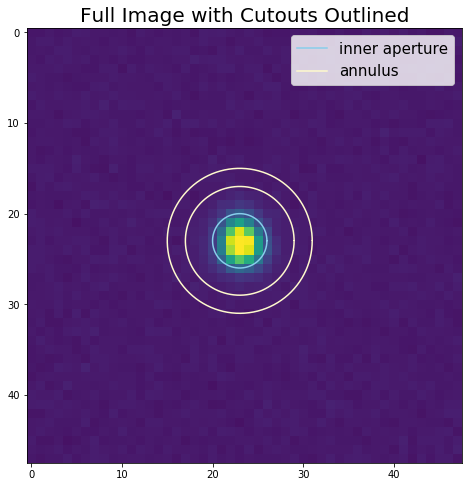

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

plt.imshow(image_data, vmin=-1000, vmax=20000,)
plt.plot(x1, y1, color='skyblue', label="inner aperture")
plt.plot(x2, y2, color='lemonchiffon', label="annulus")
plt.plot(x3, y3, color='lemonchiffon')
plt.title("Full Image with Cutouts Outlined", fontsize=20)
plt.legend(fontsize=15)

#### Looks Good. 
Now, we're going to actually create the aperture and annulus and double check that we have the right data. 

### CircularAperture and CircularAnnulus objects
On line 3 and 4 in the cell below, we instantiate a `CircularAperture` and `CircularAnnulus` object. These objects are useful because they allow us to easily create a mask. As we went over in the python refresher notebook, masks are boolean (true/false) arrays which we can apply to another array in order to only get the values we need. For example, if we have: 
```
mask = [True, False, False, False]
x = [2, 2, 2, 2]
print(x[mask])
>>> [2, 0, 0, 0]
```

This is useful in this notebook (and your lab) because we want the average value of a very specific range of values in our image, namely the range of values in the aperture and in the annulus. The `CircularAperture` and `CircularAnnulus` objects allow us to do just that with ease. 

Before we actually determine these averages, let's verify that these functions are doing what we want. 

In [7]:
positions = [(x, y)]

aperture = CircularAperture(positions, r=ap_radius)
annulus = CircularAnnulus(positions, r_in=an_radius_in, r_out=an_radius_out)

#get the data in the aperture (for plotting)
aperture_masks = aperture.to_mask()
aperture_data = aperture_masks[0].multiply(image_data)

#get the data in the annulus (for plotting)
annulus_masks = annulus.to_mask(method='center')
annulus_data = annulus_masks[0].multiply(image_data)

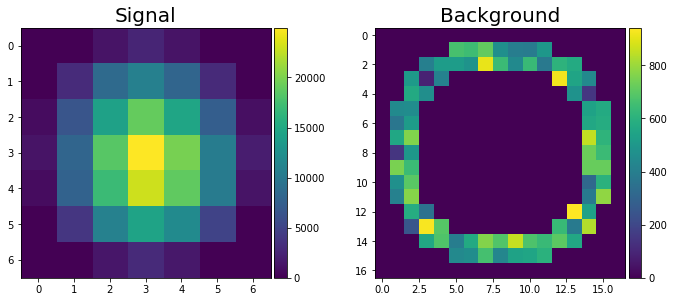

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
im1=ax1.imshow(aperture_data)#, vmin=0, vmax=20000)
im2=ax2.imshow(annulus_data)#, vmin=0, vmax=20000)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ax1.set_title("Signal", fontsize=20)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax2.set_title("Background", fontsize=20)

fig.colorbar(im1, ax=ax1, cax=cax1)
fig.colorbar(im2, ax=ax2, cax=cax2)
fig.tight_layout(pad=3.0)

This is exactly what we want. Notice the relative scaling of the colors for the background and the signal: the signal has a pixel count on the order to 20,000 while the background has a pixel count on the order of 800. This is what we expect. 

###### Everything is set up the way we want, so now let's get the data that we need. 

## Determining the Source and Background Counts
Now all we have to do is call photutil's `aperture_photometry` function, give it the image we want to analyze and the aperture/annulus we want to use, and this function will spit out a table of the total pixel count in the apertures. 

In [9]:
apers = [aperture, annulus]
phot_table = aperture_photometry(image_data, apers)

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1      23      23      320169.99      48865.748


Now to find the averages, we do the following: 

In [13]:
bkg_mean = phot_table['aperture_sum_1'] / annulus.area
bkg_mean[0] #technically bkg_mean is a column with one entry

555.5161004996347

In [14]:
data_mean = phot_table['aperture_sum_0'] / aperture.area
data_mean[0]

11323.696946815035

#### And we're done with the first image!

Since you will be running this on ~100 images, I would recommend finding a way to automate this process to make your life easier. Have fun!